In [3]:
import numpy as np
import gym
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

env = gym.make('MountainCar-v0')

def get_transformer():
    sampler = RBFSampler(gamma=2.0, n_components=1000, random_state=1234)
    """ this would be the alternative from the course solution:
    n_components=500
    sampler = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])"""
    
    #from the course solution: 
    #scaler = StandardScaler()

    observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
    #scaler.fit(observation_sample)
    #return sampler.fit(scaler.transform(observation_sample)), scaler 
    return sampler.fit(observation_sample)

In [5]:
def decide_action(predictions, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(np.stack(predictions).T)
        
        
def run(env, gamma, epsilon, render = False):
    observation = env.reset()
    # Transform observation (into higher dimensional feature space)
    #transformed_observation = transformer.transform(scaler.transform([observation]))
    transformed_observation = transformer.transform([observation])
    
    done = False
    action = None
    total_reward = 0
    while(done == False):        

        # Make prediction
        predictions = [m.predict(transformed_observation) for m in models]

        # Choose action & do step
        action = decide_action(predictions, epsilon)
        next_observation, reward, done, info = env.step(action)
        next_transformed_observation = transformer.transform([next_observation])
        
        # Make prediction and calculate value
        next_predictions = [m.predict(next_transformed_observation) for m in models]
        new_value = reward + gamma * max(next_predictions)
        
        # Update models
        models[action].partial_fit(transformed_observation, [new_value[0]])
        
        # Update observation:
        observation = next_observation
        transformed_observation = next_transformed_observation
        
        if(render):
            env.render()
        total_reward += reward
        
    if(render):
        env.close()
    return total_reward 



In [4]:
from sklearn.kernel_approximation import RBFSampler

observation = env.reset()
#transformer, scaler = get_transformer()
transformer = get_transformer()
transformed_observation = transformer.transform([observation])
print('transformed_observation.shape',transformed_observation.shape)

transformed_observation.shape (1, 1000)


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Learn to drive 1
+ Fixed epsilon = 0.1
+ One RBF (gamma = 2.0) --> 1000 features

In [12]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
epsilon = 0.1
for i in range(5000):
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%100 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  100  :  -200.0
Total reward for run  200  :  -200.0
Total reward for run  300  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  500  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  700  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  900  :  -200.0
Total reward for run  1000  :  -200.0
Total reward for run  1100  :  -200.0
Total reward for run  1200  :  -183.0
Total reward for run  1300  :  -194.0
Total reward for run  1400  :  -200.0
Total reward for run  1500  :  -200.0
Total reward for run  1600  :  -197.0
Total reward for run  1700  :  -181.0
Total reward for run  1800  :  -200.0
Total reward for run  1900  :  -191.0
Total reward for run  2000  :  -199.0
Total reward for run  2100  :  -200.0
Total reward for run  2200  :  -200.0
Total reward for run  2300  :  -200.0
Total reward for run  2400  :  -200.0
Total reward for run  2500  :  -200.0
Total reward for run  2600  :  -200.0
Total reward for run 

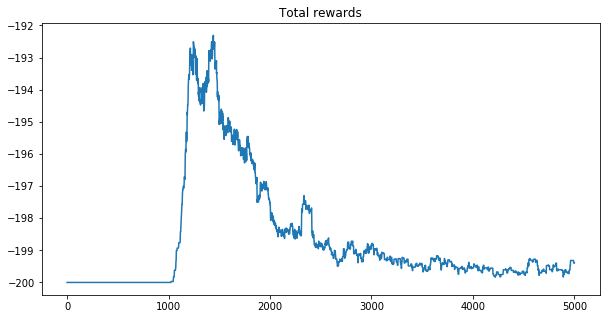

In [14]:
import matplotlib.pyplot as plt

rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")
plt.show()

In [19]:
np.exp(-0.001*5000)

0.006737946999085467

### Learn to drive 2
+ Decaying epsilon, from 0.1 to 0
+ One RBF (gamma = 2.0) --> 1000 features

In [20]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
eps_initial = 0.1
eps_decay = 0.001
for i in range(5000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%100 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  100  :  -200.0
Total reward for run  200  :  -200.0
Total reward for run  300  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  500  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  700  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  900  :  -187.0
Total reward for run  1000  :  -200.0
Total reward for run  1100  :  -186.0
Total reward for run  1200  :  -200.0
Total reward for run  1300  :  -146.0
Total reward for run  1400  :  -185.0
Total reward for run  1500  :  -177.0
Total reward for run  1600  :  -190.0
Total reward for run  1700  :  -200.0
Total reward for run  1800  :  -200.0
Total reward for run  1900  :  -194.0
Total reward for run  2000  :  -200.0
Total reward for run  2100  :  -200.0
Total reward for run  2200  :  -200.0
Total reward for run  2300  :  -200.0
Total reward for run  2400  :  -200.0
Total reward for run  2500  :  -200.0
Total reward for run  2600  :  -200.0
Total reward for run 

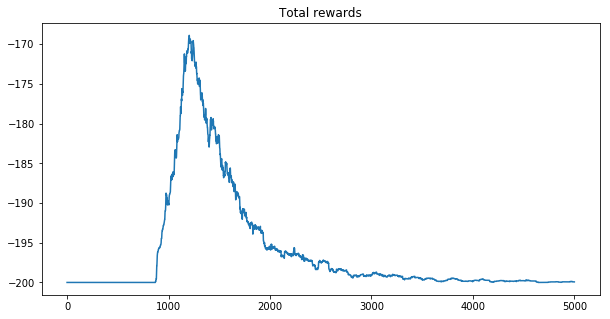

In [21]:
import matplotlib.pyplot as plt

rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")
plt.show()

### Include sklearn's StandardScaler

In [22]:
import numpy as np
import gym
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

env = gym.make('MountainCar-v0')

def get_transformer():
    sampler = RBFSampler(gamma=2.0, n_components=1000, random_state=1234)
    """ this would be the alternative from the course solution:
    n_components=500
    sampler = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])"""
    
    #from the course solution: 
    scaler = StandardScaler()

    observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
    scaler.fit(observation_sample)
    return sampler.fit(scaler.transform(observation_sample)), scaler 

In [23]:
def decide_action(predictions, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(np.stack(predictions).T)
        
        
def run(env, gamma, epsilon, render = False):
    observation = env.reset()
    # Transform observation (into higher dimensional feature space)
    transformed_observation = transformer.transform(scaler.transform([observation]))
    
    done = False
    action = None
    total_reward = 0
    while(done == False):        

        # Make prediction
        predictions = [m.predict(transformed_observation) for m in models]
        # Choose action & do step
        action = decide_action(predictions, epsilon)
        next_observation, reward, done, info = env.step(action)
        next_transformed_observation = transformer.transform(scaler.transform([next_observation]))
        
        # Make prediction and calculate value
        next_predictions = [m.predict(next_transformed_observation) for m in models]
        new_value = reward + gamma * max(next_predictions)
        
        # Update models
        models[action].partial_fit(transformed_observation, [new_value[0]])
        
        # Update observation:
        observation = next_observation
        transformed_observation = next_transformed_observation
        
        if(render):
            env.render()
        total_reward += reward
        
    if(render):
        env.close()
    return total_reward 

In [25]:
observation = env.reset()
transformer, scaler = get_transformer()
transformed_observation = transformer.transform([observation])
print('transformed_observation.shape',transformed_observation.shape)

transformed_observation.shape (1, 1000)


### Learn to drive 3
+ Fixed epsilon = 0.1
+ One RBF (gamma = 2.0) --> 1000 features
+ Include StandardScaler to scale observations

In [26]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
epsilon = 0.1
for i in range(5000):
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%100 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  100  :  -200.0
Total reward for run  200  :  -200.0
Total reward for run  300  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  500  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  700  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  900  :  -200.0
Total reward for run  1000  :  -200.0
Total reward for run  1100  :  -200.0
Total reward for run  1200  :  -200.0
Total reward for run  1300  :  -200.0
Total reward for run  1400  :  -200.0
Total reward for run  1500  :  -197.0
Total reward for run  1600  :  -200.0
Total reward for run  1700  :  -200.0
Total reward for run  1800  :  -154.0
Total reward for run  1900  :  -200.0
Total reward for run  2000  :  -166.0
Total reward for run  2100  :  -200.0
Total reward for run  2200  :  -168.0
Total reward for run  2300  :  -160.0
Total reward for run  2400  :  -155.0
Total reward for run  2500  :  -161.0
Total reward for run  2600  :  -124.0
Total reward for run 

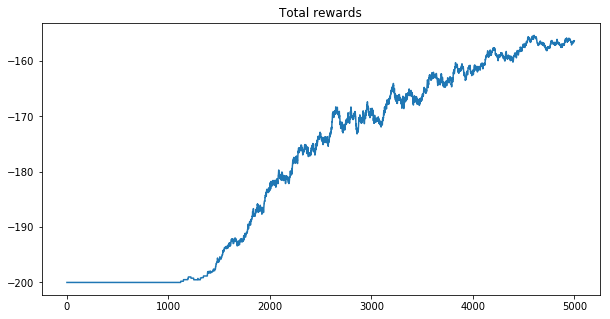

In [27]:
import matplotlib.pyplot as plt

rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")
plt.show()

### Learn to drive 4
+ Decaying epsilon = 0.1 --> 0 
+ One RBF (gamma = 2.0) --> 1000 features
+ Include StandardScaler to scale observations

In [29]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
eps_initial = 0.1
eps_decay = 0.001
for i in range(5000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%100 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  100  :  -200.0
Total reward for run  200  :  -200.0
Total reward for run  300  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  500  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  700  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  900  :  -200.0
Total reward for run  1000  :  -200.0
Total reward for run  1100  :  -200.0
Total reward for run  1200  :  -200.0
Total reward for run  1300  :  -200.0
Total reward for run  1400  :  -176.0
Total reward for run  1500  :  -200.0
Total reward for run  1600  :  -200.0
Total reward for run  1700  :  -200.0
Total reward for run  1800  :  -180.0
Total reward for run  1900  :  -200.0
Total reward for run  2000  :  -200.0
Total reward for run  2100  :  -200.0
Total reward for run  2200  :  -157.0
Total reward for run  2300  :  -162.0
Total reward for run  2400  :  -200.0
Total reward for run  2500  :  -200.0
Total reward for run  2600  :  -160.0
Total reward for run 

In [31]:
# Train a bit longer
for i in range(5000, 8000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  5200  :  -150.0
Total reward for run  5400  :  -94.0
Total reward for run  5600  :  -155.0
Total reward for run  5800  :  -95.0
Total reward for run  6000  :  -175.0
Total reward for run  6200  :  -90.0
Total reward for run  6400  :  -88.0
Total reward for run  6600  :  -151.0
Total reward for run  6800  :  -88.0
Total reward for run  7000  :  -150.0
Total reward for run  7200  :  -159.0
Total reward for run  7400  :  -91.0
Total reward for run  7600  :  -152.0
Total reward for run  7800  :  -157.0
Total reward for run  8000  :  -157.0


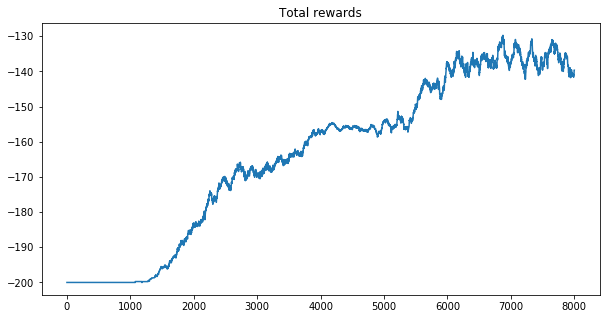

In [34]:
rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")
plt.show()

### Plot average together with rewards for individual runs

In [45]:
# Train even longer....
for i in range(8000, 12000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  8200  :  -158.0
Total reward for run  8400  :  -165.0
Total reward for run  8600  :  -87.0
Total reward for run  8800  :  -165.0
Total reward for run  9000  :  -148.0
Total reward for run  9200  :  -148.0
Total reward for run  9400  :  -84.0
Total reward for run  9600  :  -87.0
Total reward for run  9800  :  -146.0
Total reward for run  10000  :  -147.0
Total reward for run  10200  :  -148.0
Total reward for run  10400  :  -151.0
Total reward for run  10600  :  -144.0
Total reward for run  10800  :  -144.0
Total reward for run  11000  :  -158.0
Total reward for run  11200  :  -141.0
Total reward for run  11400  :  -143.0
Total reward for run  11600  :  -154.0
Total reward for run  11800  :  -141.0
Total reward for run  12000  :  -141.0


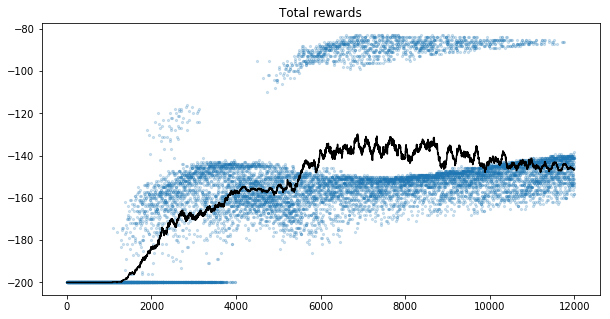

In [47]:
rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())
    
fig = plt.figure(figsize=(10, 5))
plt.scatter(np.arange(0,12000), rewards, alpha=0.2, s = 5)
plt.plot(avg_reward, color='black')
plt.title("Total rewards")
plt.show()

### Learn to drive 5
+ epsilon = 0 !
+ One RBF (gamma = 2.0) --> 1000 features
+ Include StandardScaler to scale observations

In [53]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
epsilon = 0
for i in range(10000):
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  200  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  1000  :  -200.0
Total reward for run  1200  :  -200.0
Total reward for run  1400  :  -198.0
Total reward for run  1600  :  -200.0
Total reward for run  1800  :  -200.0
Total reward for run  2000  :  -155.0
Total reward for run  2200  :  -167.0
Total reward for run  2400  :  -157.0
Total reward for run  2600  :  -152.0
Total reward for run  2800  :  -200.0
Total reward for run  3000  :  -143.0
Total reward for run  3200  :  -183.0
Total reward for run  3400  :  -158.0
Total reward for run  3600  :  -155.0
Total reward for run  3800  :  -144.0
Total reward for run  4000  :  -158.0
Total reward for run  4200  :  -160.0
Total reward for run  4400  :  -159.0
Total reward for run  4600  :  -177.0
Total reward for run  4800  :  -162.0
Total reward for run  5000  :  -162.0
Total reward for run  5200  :  -101.0
Total reward for

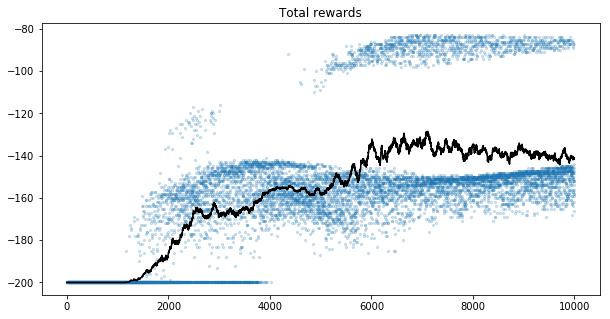

In [54]:
rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())
    
fig = plt.figure(figsize=(10, 5))
plt.scatter(np.arange(0,len(rewards)), rewards, alpha=0.2, s = 5)
plt.plot(avg_reward, color='black')
plt.title("Total rewards")
plt.show()

### Include sklearn's StandardScaler & FeatureUnion (multipl RBF gammas)

In [55]:
import numpy as np
import gym
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

env = gym.make('MountainCar-v0')

def get_transformer():
    #sampler = RBFSampler(gamma=2.0, n_components=1000, random_state=1234)
    n_components=500
    sampler = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    
    #from the course solution: 
    scaler = StandardScaler()

    observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
    scaler.fit(observation_sample)
    return sampler.fit(scaler.transform(observation_sample)), scaler 

In [56]:
def decide_action(predictions, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(np.stack(predictions).T)
        
        
def run(env, gamma, epsilon, render = False):
    observation = env.reset()
    # Transform observation (into higher dimensional feature space)
    transformed_observation = transformer.transform(scaler.transform([observation]))
    
    done = False
    action = None
    total_reward = 0
    while(done == False):        

        # Make prediction
        predictions = [m.predict(transformed_observation) for m in models]
        # Choose action & do step
        action = decide_action(predictions, epsilon)
        next_observation, reward, done, info = env.step(action)
        next_transformed_observation = transformer.transform(scaler.transform([next_observation]))
        
        # Make prediction and calculate value
        next_predictions = [m.predict(next_transformed_observation) for m in models]
        new_value = reward + gamma * max(next_predictions)
        
        # Update models
        models[action].partial_fit(transformed_observation, [new_value[0]])
        
        # Update observation:
        observation = next_observation
        transformed_observation = next_transformed_observation
        
        if(render):
            env.render()
        total_reward += reward
        
    if(render):
        env.close()
    return total_reward 

In [57]:
observation = env.reset()
transformer, scaler = get_transformer()
transformed_observation = transformer.transform([observation])
print('transformed_observation.shape',transformed_observation.shape)

transformed_observation.shape (1, 2000)


### Learn to drive 6
+ Decaying epsilon = 0.1 --> 0 
+ Stack of 4 RBFs --> 2000 features
+ Include StandardScaler to scale observations

In [58]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
rewards = []
gamma = 0.99
eps_initial = 0.1
eps_decay = 0.001
for i in range(5000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  200  :  -200.0
Total reward for run  400  :  -172.0
Total reward for run  600  :  -200.0
Total reward for run  800  :  -150.0
Total reward for run  1000  :  -160.0
Total reward for run  1200  :  -143.0
Total reward for run  1400  :  -118.0
Total reward for run  1600  :  -118.0
Total reward for run  1800  :  -107.0
Total reward for run  2000  :  -109.0
Total reward for run  2200  :  -110.0
Total reward for run  2400  :  -84.0
Total reward for run  2600  :  -118.0
Total reward for run  2800  :  -112.0
Total reward for run  3000  :  -110.0
Total reward for run  3200  :  -113.0
Total reward for run  3400  :  -107.0
Total reward for run  3600  :  -106.0
Total reward for run  3800  :  -113.0
Total reward for run  4000  :  -85.0
Total reward for run  4200  :  -108.0
Total reward for run  4400  :  -93.0
Total reward for run  4600  :  -148.0
Total reward for run  4800  :  -104.0
Total reward for run  5000  :  -91.0


In [68]:
# Continue training...
for i in range(12000, 16000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    rewards.append(run(env, gamma, epsilon)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", rewards[-1])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  12200  :  -140.0
Total reward for run  12400  :  -138.0
Total reward for run  12600  :  -84.0
Total reward for run  12800  :  -182.0
Total reward for run  13000  :  -86.0
Total reward for run  13200  :  -141.0
Total reward for run  13400  :  -143.0
Total reward for run  13600  :  -139.0
Total reward for run  13800  :  -147.0
Total reward for run  14000  :  -154.0
Total reward for run  14200  :  -161.0
Total reward for run  14400  :  -139.0
Total reward for run  14600  :  -87.0
Total reward for run  14800  :  -138.0
Total reward for run  15000  :  -141.0
Total reward for run  15200  :  -85.0
Total reward for run  15400  :  -154.0
Total reward for run  15600  :  -138.0
Total reward for run  15800  :  -86.0
Total reward for run  16000  :  -149.0


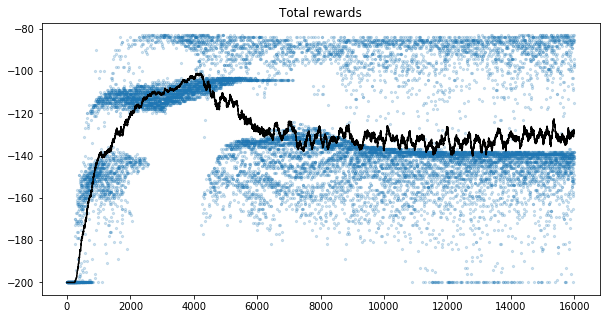

In [69]:
rewards_array = np.array(rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())
    
fig = plt.figure(figsize=(10, 5))
plt.scatter(np.arange(0,len(rewards)), rewards, alpha=0.2, s = 5)
plt.plot(avg_reward, color='black')
plt.title("Total rewards")
plt.show()

### Render runs

In [84]:
# Render runs to see what it does....
run(env, gamma, 0, render = True)

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-148.0

### -- end --
### Initial playing around with the SGDRegressor...

In [1]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor()
model.partial_fit([[0,0]], [0])
model.predict([[0, 0]])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([0.])

In [2]:
model.predict([[0, 1]])

array([0.])

In [3]:
model.partial_fit([[1,0]],[1])

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [308]:
# display one run
run(env, 0.99, 0.0, render = True)

C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


-86.0

In [243]:
action = 1
next_observation, reward, done, info = env.step(action)
print(next_observation, reward)
print(transformer.transform([next_observation])[0][:20])

[-5.26719647e-01 -2.67912820e-04] -1.0
[-0.04068231 -0.0632352   0.04236201 -0.0618868   0.00198771  0.06286966
 -0.01759054  0.00916721 -0.06232915  0.04857261  0.05658071 -0.04175123
  0.01565441 -0.01904836  0.06323999  0.00160379  0.04682458  0.06302005
  0.02869552  0.0604617 ]


In [244]:
scaler.transform([next_observation])

array([[-0.4250226,  0.00044  ]])

In [245]:
predictions = [m.predict(transformer.transform([next_observation])) for m in models]
print(np.argmax(np.stack(predictions).T))
print([m.predict(transformer.transform([next_observation])) for m in models])

2
[array([-43.05265893]), array([-43.03955614]), array([-43.0311854])]


In [21]:
next_transformed_observation = transformer.transform([next_observation])
next_predictions = [m.predict(next_transformed_observation) for m in models]

In [22]:
next_predictions

[array([0.]), array([0.]), array([0.])]

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
scaler.fit(observation_sample)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [222]:
next_observation_scaled = scaler.transform([next_observation])

In [225]:
print(next_observation_scaled, next_observation)

[[-0.5064451  -0.08041898]] [-0.56120488 -0.0028085 ]
